# AVERAGE PRECISION 

In [1]:
import sys
import numpy as np
from datetime import datetime
import pandas as pd
import argparse
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import sklearn
sys.path.append('../')
from utils import *
#from utils.feature_selection import *
from plot import *
from simulation_setup import *
from models import *
from models.forests import *
from models.Extended_IF import *
from models.Extended_DIFFI import *
from models.Extended_DIFFI_original import *
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.metrics import classification_report,average_precision_score,roc_auc_score
import math
import seaborn as sns
sns.set()

import os
import pickle 
import scipy.io

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

## Average Precision Functions 

plus = 1 -> EIF+ Model

plus = 0 -> EIF Model 

plus in [0,1] -> EIF Hybrid Model 

In [2]:
def evaluate_precisions(X_train,X_test,y,name):
    EIF = ExtendedIsolationForest(n_estimators=300,plus=0)
    EIF.fit(X_train)
    EIF_plus=ExtendedIsolationForest(n_estimators=300,plus=1)
    EIF_plus.fit(X_train)
    iforest = IsolationForest(n_estimators=300,max_samples=256)
    iforest.fit(X_train)
    score = EIF.predict(X_test)
    precision_EIF = average_precision_score(y,score)
    score_plus = EIF_plus.predict(X_test)
    precision_EIF_plus = average_precision_score(y,score_plus)
    scoreif = -1*iforest.score_samples(X_test)+0.5
    precision_IF = average_precision_score(y,scoreif)

    d={
    'score':[score,score_plus,scoreif],
    'average_precision':[precision_EIF,precision_EIF_plus,precision_IF],
    'contamination':sum(y)/len(y),'real label': y
    }

    pwd='c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'
    path=pwd+'\\results\\davide\\info_violin\\info_violin_'+str(name) + '_split.pkl'
    with open(path, 'wb') as f:
        pickle.dump(d,f)
    
    return precision_IF,precision_EIF,precision_EIF_plus

In [4]:
def collect_precisions(Precisions_scores,name,X_train,X_test,y):
    Precisions_scores[name]={}
    Precisions_scores[name]['IF']=[]
    Precisions_scores[name]['EIF']=[]
    Precisions_scores[name]['EIF_plus']=[]
    for i in tqdm(range(10)):
        precision_IF,precision_EIF,precision_EIF_plus = evaluate_precisions(X_train,X_test,y,name)
        Precisions_scores[name]['IF'].append(precision_IF)
        Precisions_scores[name]['EIF'].append(precision_EIF)
        Precisions_scores[name]['EIF_plus'].append(precision_EIF_plus)
    return Precisions_scores

The combination of the evaluate_precision and collect_precisions functions returns a dictionary in which for each dataset we have a key value pair where the key is the dataset name and the value is a pair of lists -> one for IF (Isolation Forest) and one for EIF (Extended Isolation Forest). These two lists contain the Average Precision for 25 different instances of the two models. We try multiple executions because of the stochasticity of the model. In this way we can aggregate the results later on and summarize which model is the best. 

In [5]:
def partition_data(X,y):
    inliers=X[y==0,:]
    outliers=X[y==1,:]
    return inliers,outliers

# Synthetic Datasets 

## Load pkl files 

In [6]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [7]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [8]:
file_to_read = open(os.getcwd()+'\\anomalies.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d=loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisec'],loaded_dictionary['X_bisec_3d'],loaded_dictionary['X_bisec_6d']

In [8]:
file_to_read = open(os.getcwd()+'\\syn_test_anomaly_interval.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisec = loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisect']

In [9]:
file_to_read = open(os.getcwd()+'\\syn_test_multi_dim_anomaly_interval.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_bisect_3d,X_bisect_4d,X_bisect_6d = loaded_dictionary['X_bisect_3d'],loaded_dictionary['X_bisect_4d'],loaded_dictionary['X_bisect_6d']

# Precisions Score Computation Function

## Synthetic Datasets

In [9]:
def precisions_scores_synt(name,X_train,X_test,Precisions_scores,Precisions_scores_split):
    
    X=np.r_[X_train,X_test]
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    #X=scaler2.fit_transform(X)

    # Compute precision scores without split
    Precisions_scores=collect_precisions(Precisions_scores,name,X_test,X_test,y)
    # Compute precision scores with split
    Precisions_scores_split=collect_precisions(Precisions_scores_split,name,X_train,X_test,y)

    print('--------------------------------------------------------')
    print(name)
    print()
    print('Precision Scores no train test split ')
    print('IF -> ' + str(np.mean(Precisions_scores[name]['IF'])))
    print('EIF -> ' + str(np.mean(Precisions_scores[name]['EIF'])))
    print('EIF_plus -> ' + str(np.mean(Precisions_scores[name]['EIF_plus'])))
    print(' ')
     
    print('Precision Scores with train test split ')
    print('IF -> ' + str(np.mean(Precisions_scores_split[name]['IF'])))
    print('EIF -> ' + str(np.mean(Precisions_scores_split[name]['EIF'])))
    print('EIF_plus -> ' + str(np.mean(Precisions_scores_split[name]['EIF_plus'])))
    print('-----------------------------------------------------------')
    

    #return Precisions_scores
    return Precisions_scores,Precisions_scores_split


In [21]:
def precisions_scores(name,Precisions_scores,Precisions_scores_split):

    if name=='diabetes' or name=='moodify':
        X,y=csv_dataset(name,os.getcwd()+'\\')
    else:
        X,y=dataset(name,os.getcwd()+'\\')
    
    X,y=downsample(X,y)
    X_train,X_test=partition_data(X,y)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y2=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    X=scaler2.fit_transform(X)

    Precisions_scores = collect_precisions(Precisions_scores,name,X,X,y)
    Precisions_scores_split = collect_precisions(Precisions_scores_split,name,X_train,X_test,y2)

    print('--------------------------------------------------------')
    print(name)
    print()
    
    print('Precision Scores no train test split ')
    print('IF -> ' + str(np.mean(Precisions_scores[name]['IF'])))
    print('EIF -> ' + str(np.mean(Precisions_scores[name]['EIF'])))
    print('EIF_plus -> ' + str(np.mean(Precisions_scores[name]['EIF_plus'])))
    print(' ')
    
    print('Precision Scores with train test split ')
    print('IF -> ' + str(np.mean(Precisions_scores_split[name]['IF'])))
    print('EIF -> ' + str(np.mean(Precisions_scores_split[name]['EIF'])))
    print('EIF_plus -> ' + str(np.mean(Precisions_scores_split[name]['EIF_plus'])))
    print('-----------------------------------------------------------')
    
    #return Precisions_scores_split
    return Precisions_scores,Precisions_scores_split


In [10]:
Precisions_scores={}
Precisions_scores_split={}

## Real World Dataset 

In [19]:
def csv_dataset(name, path = "../data/"):
    datapath = path + name + ".csv"
    data=pd.read_csv(datapath,index_col=0)
    if 'Unnamed: 0' in data.columns:
        data=data.drop(columns=['Unnamed: 0'])
    
    X=data[data.columns[data.columns!='Target']]
    y=data['Target']
    
    X,y = drop_duplicates(X,y)
    print(name, "\n")
    print_dataset_resume(X,y)
    
    return X,y

In [20]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')

In [22]:
dataset_names=['wine','annthyroid','breastw','shuttle','pima','cardio','glass',
             'ionosphere','pendigits','diabetes','moodify']
for name in dataset_names:
    Precisions_scores,Precisions_scores_split=precisions_scores(name,Precisions_scores,Precisions_scores_split)

wine 

[numero elementi = 129]
[percentage outliers = 0.07751937984496124]
[number features = 13]
[number outliers = 10]


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (129). max_samples will be set to n_samples for estimation.
  warn(
 10%|█         | 1/10 [00:05<00:45,  5.07s/it]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (129). max_samples will be set to n_samples for estimation.
  warn(
 20%|██        | 2/10 [00:09<00:35,  4.42s/it]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (129). max_samples 

--------------------------------------------------------
wine

Precision Scores no train test split 
IF -> 0.2013251558803381
EIF -> 0.2162408766690596
EIF_plus -> 0.17871680006907303
 
Precision Scores with train test split 
IF -> 0.45316902846734486
EIF -> 0.5301164461968237
EIF_plus -> 0.7624548064164938
-----------------------------------------------------------
annthyroid 

[numero elementi = 7062]
[percentage outliers = 0.07561597281223449]
[number features = 6]
[number outliers = 534]
downsampled to 2500
(2500, 6)


100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


--------------------------------------------------------
annthyroid

Precision Scores no train test split 
IF -> 0.34285940641506696
EIF -> 0.22266200257065863
EIF_plus -> 0.22256957459578391
 
Precision Scores with train test split 
IF -> 0.5334053614365691
EIF -> 0.488576159583946
EIF_plus -> 0.5234646543776693
-----------------------------------------------------------
breastw 

[numero elementi = 449]
[percentage outliers = 0.5256124721603563]
[number features = 9]
[number outliers = 236]


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (213). max_samples will be set to n_samples for estimation.
  warn(
 10%|█         | 1/10 [00:04<00:43,  4.88s/it]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (213). max_samples will be set to n_samples for estimation.
  warn(
 20%|██        | 2/10 [00:09<00:40,  5.02s/it]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total

--------------------------------------------------------
breastw

Precision Scores no train test split 
IF -> 0.9536667552016782
EIF -> 0.9153669099043181
EIF_plus -> 0.889702139036566
 
Precision Scores with train test split 
IF -> 0.9907148771229304
EIF -> 0.9855246998793126
EIF_plus -> 0.990640527377024
-----------------------------------------------------------
shuttle 

[numero elementi = 49097]
[percentage outliers = 0.0715114976475141]
[number features = 9]
[number outliers = 3511]
downsampled to 2500
(2500, 9)


100%|██████████| 10/10 [01:23<00:00,  8.33s/it]


--------------------------------------------------------
shuttle

Precision Scores no train test split 
IF -> 0.9872202009702924
EIF -> 0.9358237731486181
EIF_plus -> 0.8780328195548076
 
Precision Scores with train test split 
IF -> 0.9856902022328298
EIF -> 0.9048683863171627
EIF_plus -> 0.9166908858799966
-----------------------------------------------------------
pima 

[numero elementi = 768]
[percentage outliers = 0.3489583333333333]
[number features = 8]
[number outliers = 268]


100%|██████████| 10/10 [00:58<00:00,  5.81s/it]


--------------------------------------------------------
pima

Precision Scores no train test split 
IF -> 0.5055135048397863
EIF -> 0.49105985511254857
EIF_plus -> 0.4863733179544196
 
Precision Scores with train test split 
IF -> 0.579802875581097
EIF -> 0.5522594967565835
EIF_plus -> 0.5811902258093904
-----------------------------------------------------------
cardio 

[numero elementi = 1822]
[percentage outliers = 0.09604829857299671]
[number features = 21]
[number outliers = 175]


100%|██████████| 10/10 [01:17<00:00,  7.78s/it]


--------------------------------------------------------
cardio

Precision Scores no train test split 
IF -> 0.5831106956471226
EIF -> 0.5697597522353292
EIF_plus -> 0.5255571264282974
 
Precision Scores with train test split 
IF -> 0.6910216013993427
EIF -> 0.7344000070640078
EIF_plus -> 0.7757110735742849
-----------------------------------------------------------
glass 

[numero elementi = 213]
[percentage outliers = 0.04225352112676056]
[number features = 9]
[number outliers = 9]


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (213). max_samples will be set to n_samples for estimation.
  warn(
 10%|█         | 1/10 [00:05<00:47,  5.26s/it]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (213). max_samples will be set to n_samples for estimation.
  warn(
 20%|██        | 2/10 [00:09<00:37,  4.65s/it]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total

--------------------------------------------------------
glass

Precision Scores no train test split 
IF -> 0.10924811351510806
EIF -> 0.09150192606494918
EIF_plus -> 0.12747850066412325
 
Precision Scores with train test split 
IF -> 0.09918003089938696
EIF -> 0.09329953504983099
EIF_plus -> 0.20374334076977388
-----------------------------------------------------------
ionosphere 

[numero elementi = 350]
[percentage outliers = 0.35714285714285715]
[number features = 33]
[number outliers = 125]


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (225). max_samples will be set to n_samples for estimation.
  warn(
 10%|█         | 1/10 [00:05<00:51,  5.73s/it]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (225). max_samples will be set to n_samples for estimation.
  warn(
 20%|██        | 2/10 [00:11<00:46,  5.76s/it]C:\Users\lemeda98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total

--------------------------------------------------------
ionosphere

Precision Scores no train test split 
IF -> 0.8139092726369774
EIF -> 0.82980941611962
EIF_plus -> 0.8475483832373358
 
Precision Scores with train test split 
IF -> 0.8892312249102929
EIF -> 0.914754168098699
EIF_plus -> 0.9608850454787964
-----------------------------------------------------------
pendigits 

[numero elementi = 6870]
[percentage outliers = 0.022707423580786028]
[number features = 16]
[number outliers = 156]
downsampled to 2500
(2500, 16)


100%|██████████| 10/10 [01:29<00:00,  8.95s/it]


--------------------------------------------------------
pendigits

Precision Scores no train test split 
IF -> 0.32427822918912147
EIF -> 0.2833506909697553
EIF_plus -> 0.2813864292474736
 
Precision Scores with train test split 
IF -> 0.40736827934268316
EIF -> 0.3333942165097508
EIF_plus -> 0.40917117610295745
-----------------------------------------------------------
diabetes 

[numero elementi = 85916]
[percentage outliers = 0.096582708692211]
[number features = 4]
[number outliers = 8298]
downsampled to 2500
(2500, 4)


100%|██████████| 10/10 [01:54<00:00, 11.48s/it]


--------------------------------------------------------
diabetes

Precision Scores no train test split 
IF -> 0.47429379371397873
EIF -> 0.44291349331164775
EIF_plus -> 0.4301249936982362
 
Precision Scores with train test split 
IF -> 0.21027720185872972
EIF -> 0.4982899264236984
EIF_plus -> 0.5897407269844267
-----------------------------------------------------------
moodify 

[numero elementi = 276260]
[percentage outliers = 0.1527112140736987]
[number features = 11]
[number outliers = 42188]
downsampled to 2500
(2500, 11)


100%|██████████| 10/10 [01:56<00:00, 11.64s/it]

--------------------------------------------------------
moodify

Precision Scores no train test split 
IF -> 0.36344790486419953
EIF -> 0.34669483394436706
EIF_plus -> 0.3176412794483463
 
Precision Scores with train test split 
IF -> 0.7586802428126258
EIF -> 0.668912881089159
EIF_plus -> 0.6983946958964294
-----------------------------------------------------------


## Synthetic Dataset

In [12]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [13]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)

In [14]:
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_xaxis',X_train,X_xaxis,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_yaxis',X_train,X_yaxis,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect',X_train,X_bisect,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect_3d',X_train,X_bisect_3d,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect_6d',X_train,X_bisect_6d,Precisions_scores,Precisions_scores_split)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\lemeda98\Desktop\PHD Information Engineering\ExIFFI\ExIFFI\utils\..\models\forests.py:18: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  d = np.dot(x,normals[node_id])
100%|██████████| 10/10 [00:59<00:00,  6.00s/it]


--------------------------------------------------------
X_xaxis

Precision Scores no train test split 
IF -> 0.1115415847786279
EIF -> 0.9888019846985081
EIF_plus -> 0.9882013671590121
 
Precision Scores with train test split 
IF -> 0.1038180955524604
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


--------------------------------------------------------
X_yaxis

Precision Scores no train test split 
IF -> 0.10118558702305129
EIF -> 0.996303786343838
EIF_plus -> 0.9909177475243368
 
Precision Scores with train test split 
IF -> 0.10618788559206171
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


100%|██████████| 10/10 [00:49<00:00,  4.91s/it]


--------------------------------------------------------
X_bisect

Precision Scores no train test split 
IF -> 0.7811256961255715
EIF -> 0.9959933390435862
EIF_plus -> 0.9933729203431833
 
Precision Scores with train test split 
IF -> 1.0
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


100%|██████████| 10/10 [00:51<00:00,  5.20s/it]


--------------------------------------------------------
X_bisect_3d

Precision Scores no train test split 
IF -> 0.9772194706844051
EIF -> 0.9915142499007178
EIF_plus -> 0.9816440186018033
 
Precision Scores with train test split 
IF -> 1.0
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


100%|██████████| 10/10 [00:58<00:00,  5.84s/it]

--------------------------------------------------------
X_bisect_6d

Precision Scores no train test split 
IF -> 0.9999022276481042
EIF -> 0.9890113437210843
EIF_plus -> 0.9802169997718039
 
Precision Scores with train test split 
IF -> 1.0
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


In [37]:
Precisions_scores=precisions_scores_synt('X_xaxis',X_train,X_xaxis,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores=precisions_scores_synt('X_yaxis',X_train,X_yaxis,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores=precisions_scores_synt('X_bisect',X_train,X_bisect,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores=precisions_scores_synt('X_bisect_3d',X_train,X_bisect_3d,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores=precisions_scores_synt('X_bisect_6d',X_train,X_bisect_6d,Precisions_scores,Precisions_scores_split)

100%|██████████| 10/10 [00:52<00:00,  5.29s/it]


--------------------------------------------------------
X_xaxis

Precision Scores no train test split 
IF -> 0.10396757629976967
EIF -> 0.9862149824289386
EIF_plus -> 0.9839379441354517
 


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


--------------------------------------------------------
X_yaxis

Precision Scores no train test split 
IF -> 0.10418964474028754
EIF -> 0.9961775818086434
EIF_plus -> 0.9921491473406698
 


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


--------------------------------------------------------
X_bisect

Precision Scores no train test split 
IF -> 0.8176353715281868
EIF -> 0.99172652905679
EIF_plus -> 0.9907401526849245
 


100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


--------------------------------------------------------
X_bisect_3d

Precision Scores no train test split 
IF -> 0.9693075247980827
EIF -> 0.9855390396195727
EIF_plus -> 0.9840361716252153
 


100%|██████████| 10/10 [00:54<00:00,  5.44s/it]

--------------------------------------------------------
X_bisect_6d

Precision Scores no train test split 
IF -> 0.9992893659230224
EIF -> 0.989463476916041
EIF_plus -> 0.967815552752648
 


In [20]:
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_xaxis',X_train,X_xaxis,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_yaxis',X_train,X_yaxis,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect',X_train,X_bisect,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect_3d',X_train,X_bisect_3d,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect_6d',X_train,X_bisect_6d,Precisions_scores,Precisions_scores_split)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\lemeda98\Desktop\PHD Information Engineering\ExIFFI\ExIFFI\utils\..\models\forests.py:18: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  d = np.dot(x,normals[node_id])
100%|██████████| 10/10 [00:49<00:00,  4.95s/it]


--------------------------------------------------------
X_xaxis

Precision Scores no train test split 
IF -> 0.1115415847786279
EIF -> 0.9888019846985081
EIF_plus -> 0.9882013671590121
 
Precision Scores with train test split 
IF -> 0.1038180955524604
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


100%|██████████| 10/10 [00:47<00:00,  4.71s/it]


--------------------------------------------------------
X_yaxis

Precision Scores no train test split 
IF -> 0.10118558702305129
EIF -> 0.996303786343838
EIF_plus -> 0.9909177475243368
 
Precision Scores with train test split 
IF -> 0.10618788559206171
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


--------------------------------------------------------
X_bisect

Precision Scores no train test split 
IF -> 0.7811256961255715
EIF -> 0.9959933390435862
EIF_plus -> 0.9933729203431833
 
Precision Scores with train test split 
IF -> 1.0
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


--------------------------------------------------------
X_bisect_3d

Precision Scores no train test split 
IF -> 0.9772194706844051
EIF -> 0.9915142499007178
EIF_plus -> 0.9816440186018033
 
Precision Scores with train test split 
IF -> 1.0
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


100%|██████████| 10/10 [01:22<00:00,  8.28s/it]

--------------------------------------------------------
X_bisect_6d

Precision Scores no train test split 
IF -> 0.9999022276481042
EIF -> 0.9890113437210843
EIF_plus -> 0.9802169997718039
 
Precision Scores with train test split 
IF -> 1.0
EIF -> 1.0
EIF_plus -> 1.0
-----------------------------------------------------------


## Load the results in a pkl file 

In [26]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')

### Write in the pkl file 

In [24]:
Precisions_scores_split.keys()

dict_keys(['X_xaxis', 'X_yaxis', 'X_bisect', 'X_bisect_3d', 'X_bisect_6d', 'wine', 'annthyroid', 'breastw', 'shuttle', 'pima', 'cardio', 'glass', 'ionosphere', 'pendigits', 'diabetes', 'moodify'])

In [28]:
path = os.getcwd() + '\\results\\davide\\Performance Report\\Precisions_scores_no_split_right.pkl'
with open(path, 'wb') as f:
    pickle.dump(Precisions_scores,f)

In [70]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
path = os.getcwd() + '//results//davide//Performance Report//Precisions_scores_plus_new.pkl'
with open(path, 'wb') as f:
    pickle.dump(Precisions_scores, f)

### Read from the pkl file 

Synthetic Datasets

In [3]:
path = os.getcwd() + '\\results\\davide\\Performance Report\\Precisions_scores_no_split.pkl'
with open(path, 'rb') as f:
    Prec_score= pickle.load(f)

In [7]:
path = os.getcwd() + '\\results\\davide\\Performance Report\\Precisions_scores_plus_new.pkl'
with open(path, 'rb') as f:
    Precisions_scores = pickle.load(f)

In [37]:
del Prec_score_split['X_xaxis']
del Prec_score_split['X_yaxis']
del Prec_score_split['X_bisect']
del Prec_score_split['X_bisect_3d']
del Prec_score_split['X_bisect_6d']

In [5]:
Prec_score['X_xaxis']

{'IF': [0.10162050047312096,
  0.1590242744332651,
  0.18066060842275022,
  0.07450294072425549,
  0.07738376913128275,
  0.08752449969378612,
  0.08053363547435417,
  0.1250603992107408,
  0.09069881301049879,
  0.07953463943939365],
 'EIF': [0.44392154295215736,
  0.36600208441255333,
  0.44524350818666075,
  0.3370561171781367,
  0.4009781923181285,
  0.4029490741957771,
  0.4556067725557585,
  0.41615835639176973,
  0.38505040798516166,
  0.3278541901828324],
 'EIF_plus': [0.3511899388555198,
  0.3476897349978768,
  0.41762974643800194,
  0.33232068951105376,
  0.3506395966699836,
  0.2659518609689969,
  0.3514566548177271,
  0.34478317243731965,
  0.4403682189764855,
  0.4134584184207305]}

# Violin Plot

In [34]:
import matplotlib.patches as mpatches
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

Put all the precision scores contained in the Precision_scores dictionary in a list of lists. The list data has 20 elements. data[0] is the list containing the average precisions obtained on the 25 runs of IF on the Wine dataset, data[1] contains the same type of list but with the average precisions of EIF on Wine. And so on for all the other 9 real-world datasets. 

The second for is used to cast all the Average Precision values contained in data into float. 

## IF vs EIF 

In [155]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide\\Performance Report')
data = []

for key in Precisions_scores_no_split:     
    for algorithm in ["IF","EIF"]:
        data.append(Precisions_scores_no_split[key][algorithm])

for i in range(len(data)):
    data[i] = [float(x) for x in data[i]]


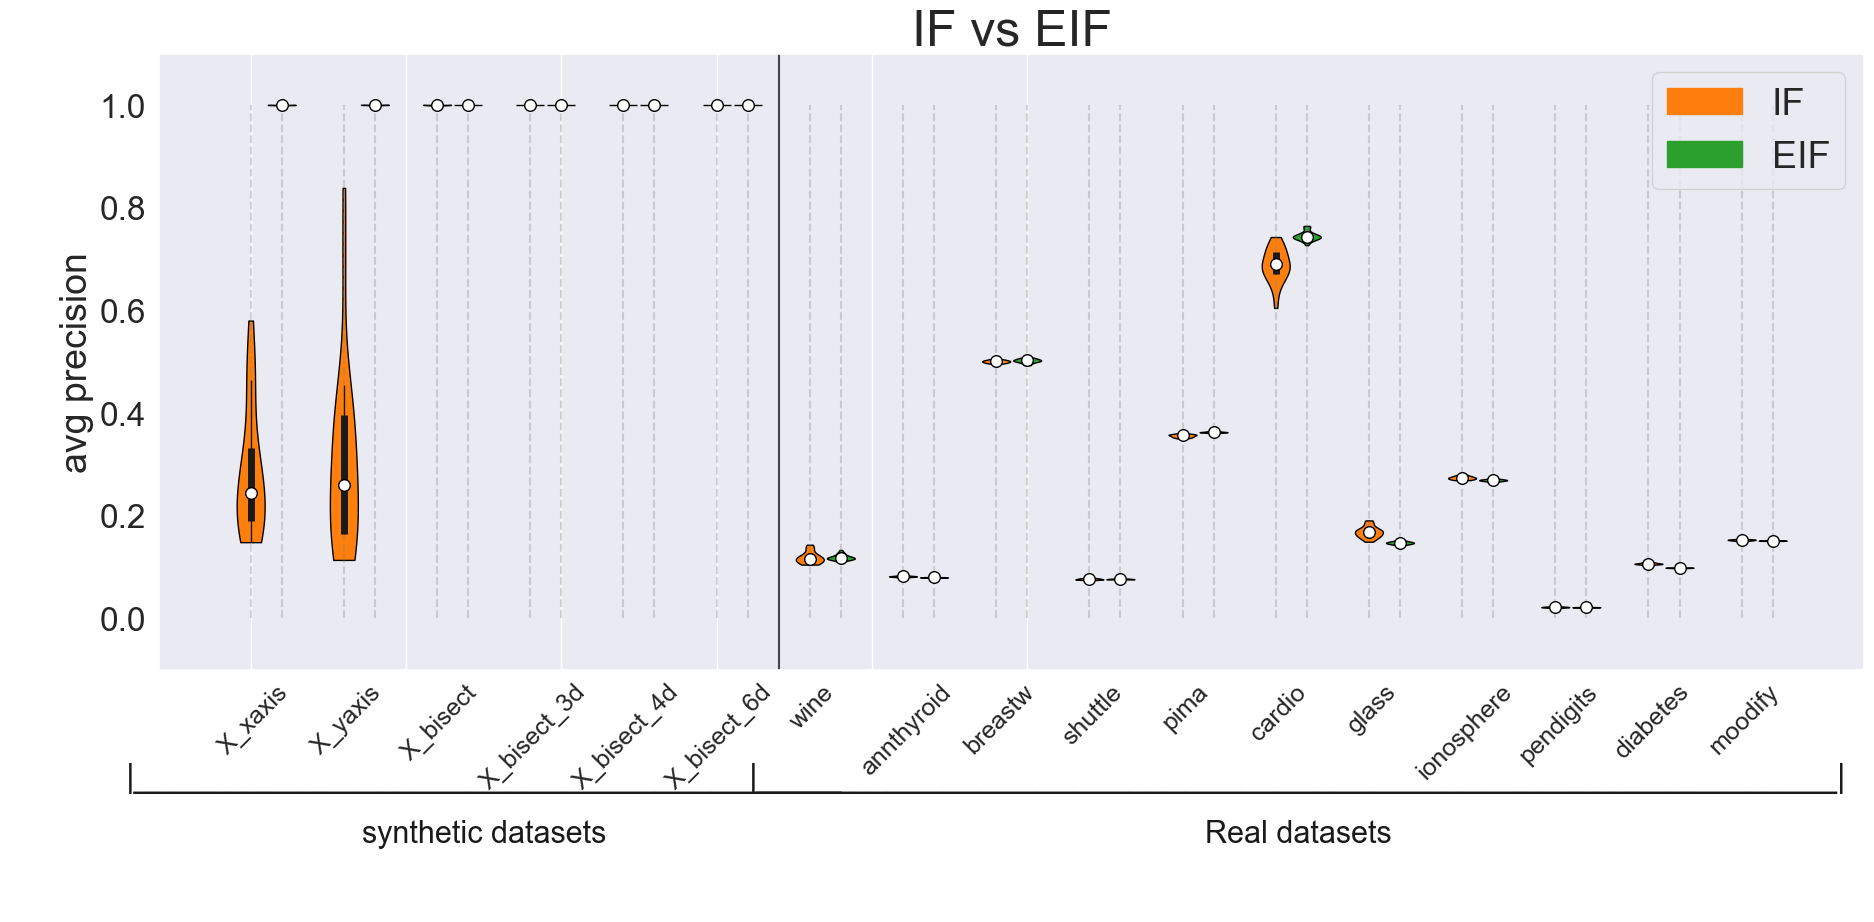

In [137]:
plt.figure(figsize=(22, 8))  
parts = plt.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths = 0.9,positions=[x+(x//2) for x in range(len(data))])

for n,pc in enumerate(parts['bodies']):
        if n%2==0:
                pc.set_facecolor('tab:orange')
        elif n%2==1:
                pc.set_facecolor('tab:green')
        pc.set_edgecolor('black')
        pc.set_alpha(1)


inds = [x+(x//2) for x in range(len(data))]

for i in inds:
        plt.plot([i,i],[0,1],'--',c="tab:gray",alpha = 0.3)

plt.plot([17,17],[-0.5,1.5],c="k",alpha = 0.8)

quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

plt.scatter(inds, medians, marker='o', color='white',edgecolors="black", s=70, zorder=3)

plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.grid(axis = "y")
plt.title('IF vs EIF',fontsize = 36)
plt.ylim(-0.1,1.1)
plt.xticks([x+0.1 for x in inds if x%3==0],list(Precision_scores_synt.keys()),minor = True,fontsize=18,rotation = 45)
plt.xticks(range(0,30,5),[""]*len(range(0,30,5)))
plt.yticks(fontsize=24)
plt.xlabel("\n \n ",fontsize=27)
plt.ylabel("avg precision",fontsize=27)
plt.annotate('|______________________________________', xy=(.220, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('synthetic datasets', xy=(.220, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')
plt.annotate('|__________________________________________________________|', xy=(.59, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('Real datasets', xy=(.59, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')

orange_patch = mpatches.Patch(color='tab:orange', label='IF')
green_patch = mpatches.Patch(color='tab:green', label='EIF')
plt.legend(handles=[orange_patch,green_patch],loc="upper right",fontsize=27)
plt.savefig(os.getcwd()+'/avgIFvsEIF_synt.pdf',bbox_inches = "tight")
plt.show()

## IF vs EIF+

In [139]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide')
data = []
for key in Precision_scores_synt:     
    for algorithm in ["IF","EIF_plus"]:
        data.append(Precision_scores_synt[key][algorithm])
    
for i in range(len(data)):
    data[i] = [float(x) for x in data[i]]

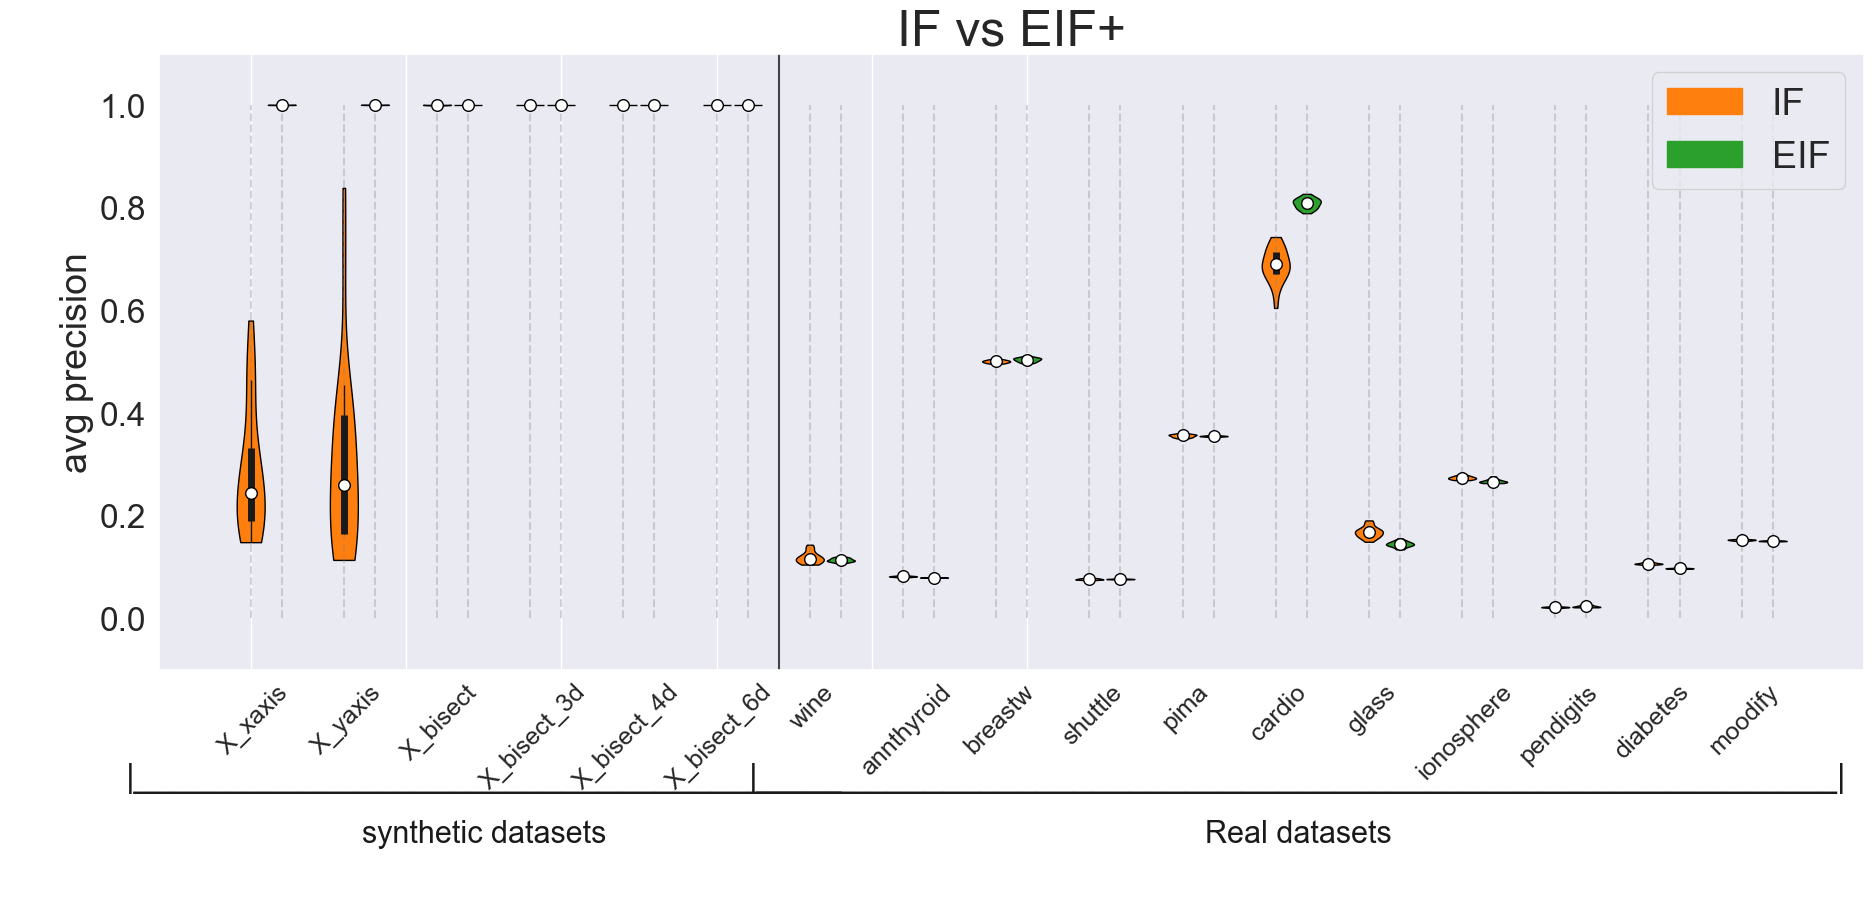

In [142]:
plt.figure(figsize=(22, 8))  
parts = plt.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths = 0.9,positions=[x+(x//2) for x in range(len(data))])

for n,pc in enumerate(parts['bodies']):
        if n%2==0:
                pc.set_facecolor('tab:orange')
        elif n%2==1:
                pc.set_facecolor('tab:green')
        pc.set_edgecolor('black')
        pc.set_alpha(1)


inds = [x+(x//2) for x in range(len(data))]

for i in inds:
        plt.plot([i,i],[0,1],'--',c="tab:gray",alpha = 0.3)

plt.plot([17,17],[-0.5,1.5],c="k",alpha = 0.8)

quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

plt.scatter(inds, medians, marker='o', color='white',edgecolors="black", s=70, zorder=3)

plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.grid(axis = "y")
plt.title('IF vs EIF+',fontsize = 36)
plt.ylim(-0.1,1.1)
plt.xticks([x+0.1 for x in inds if x%3==0],list(Precision_scores_synt.keys()),minor = True,fontsize=18,rotation = 45)
plt.xticks(range(0,30,5),[""]*len(range(0,30,5)))
plt.yticks(fontsize=24)
plt.xlabel("\n \n ",fontsize=27)
plt.ylabel("avg precision",fontsize=27)
plt.annotate('|______________________________________', xy=(.220, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('synthetic datasets', xy=(.220, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')
plt.annotate('|__________________________________________________________|', xy=(.59, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('Real datasets', xy=(.59, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')

orange_patch = mpatches.Patch(color='tab:orange', label='IF')
green_patch = mpatches.Patch(color='tab:green', label='EIF')
plt.legend(handles=[orange_patch,green_patch],loc="upper right",fontsize=27)
plt.savefig(os.getcwd()+'/avgIFvsEIF_plus_synt.pdf',bbox_inches = "tight")
plt.show()

## EIF vs EIF+

In [143]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide')
data = []
for key in Precision_scores_synt:     
    for algorithm in ["EIF","EIF_plus"]:
        data.append(Precision_scores_synt[key][algorithm])
    
for i in range(len(data)):
    data[i] = [float(x) for x in data[i]]

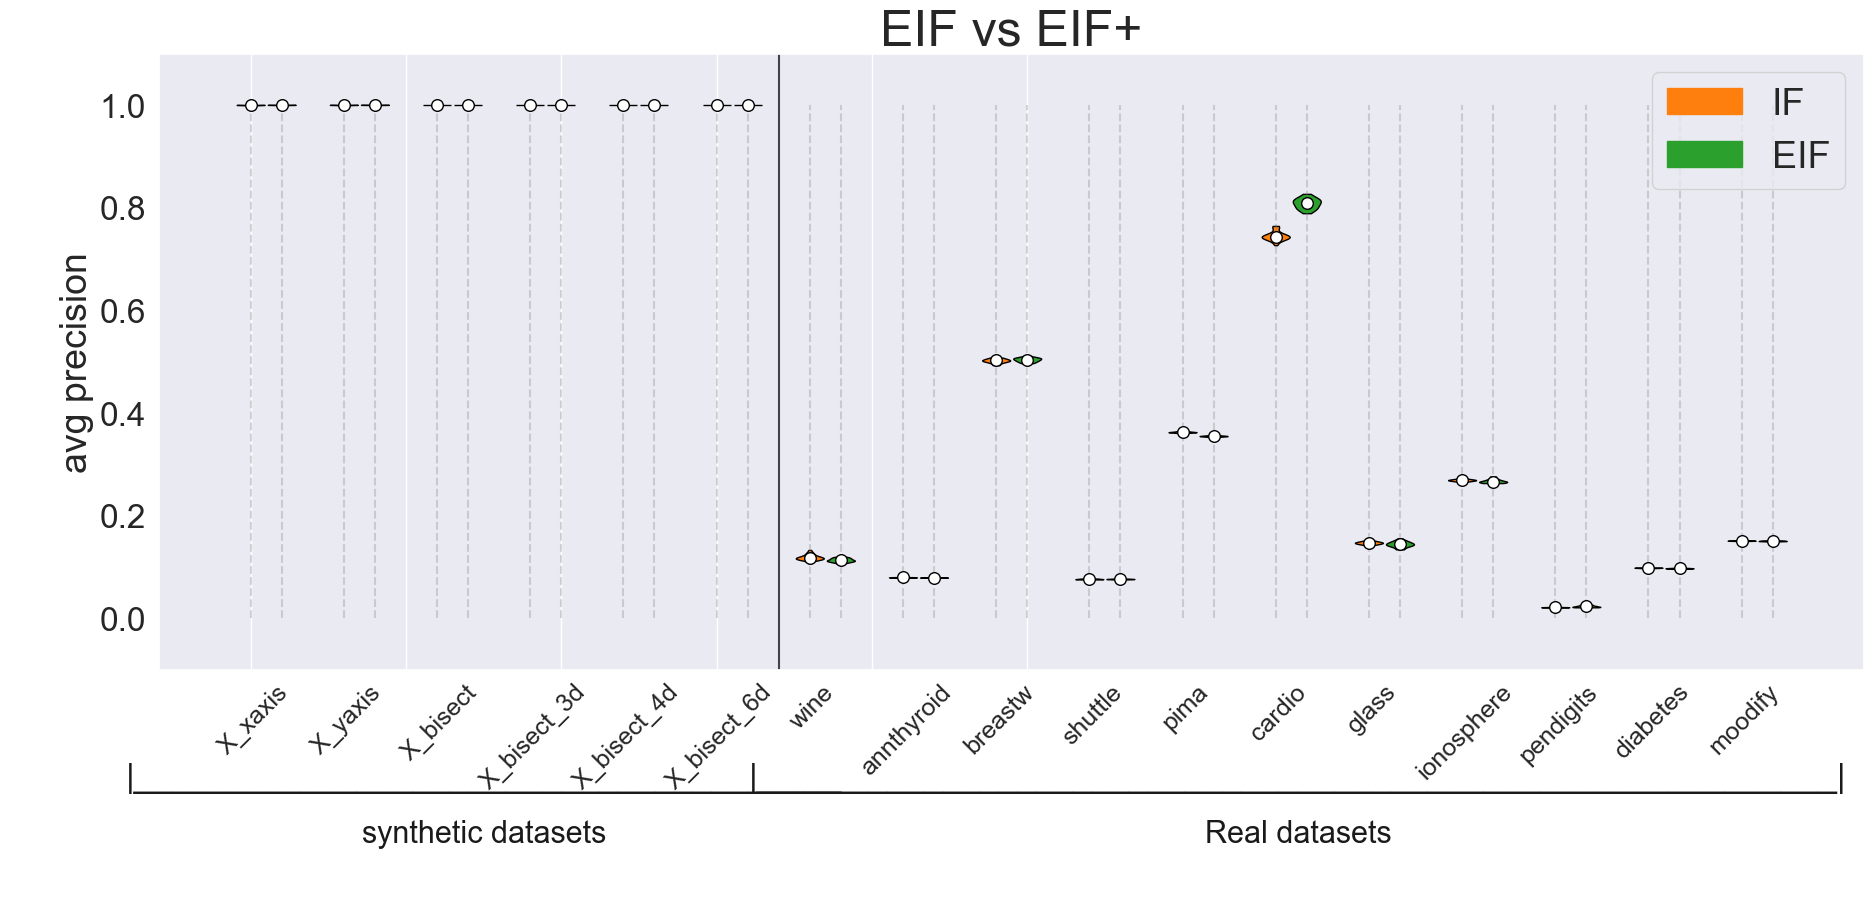

In [144]:
plt.figure(figsize=(22, 8))  
parts = plt.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths = 0.9,positions=[x+(x//2) for x in range(len(data))])

for n,pc in enumerate(parts['bodies']):
        if n%2==0:
                pc.set_facecolor('tab:orange')
        elif n%2==1:
                pc.set_facecolor('tab:green')
        pc.set_edgecolor('black')
        pc.set_alpha(1)


inds = [x+(x//2) for x in range(len(data))]

for i in inds:
        plt.plot([i,i],[0,1],'--',c="tab:gray",alpha = 0.3)

plt.plot([17,17],[-0.5,1.5],c="k",alpha = 0.8)

quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

plt.scatter(inds, medians, marker='o', color='white',edgecolors="black", s=70, zorder=3)

plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.grid(axis = "y")
plt.title('EIF vs EIF+',fontsize = 36)
plt.ylim(-0.1,1.1)
plt.xticks([x+0.1 for x in inds if x%3==0],list(Precision_scores_synt.keys()),minor = True,fontsize=18,rotation = 45)
plt.xticks(range(0,30,5),[""]*len(range(0,30,5)))
plt.yticks(fontsize=24)
plt.xlabel("\n \n ",fontsize=27)
plt.ylabel("avg precision",fontsize=27)
plt.annotate('|______________________________________', xy=(.220, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('synthetic datasets', xy=(.220, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')
plt.annotate('|__________________________________________________________|', xy=(.59, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('Real datasets', xy=(.59, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')


orange_patch = mpatches.Patch(color='tab:orange', label='IF')
green_patch = mpatches.Patch(color='tab:green', label='EIF')
plt.legend(handles=[orange_patch,green_patch],loc="upper right",fontsize=27)
plt.savefig(os.getcwd()+'/avgEIFvsEIF_plus_synt.pdf',bbox_inches = "tight")
plt.show()

## IF vs EIF vs EIF+ 

In [15]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide')
data = []
for key in Precisions_scores_synt:     
    for algorithm in ['IF',"EIF","EIF_plus"]:
        data.append(Precisions_scores_synt[key][algorithm])
    
for i in range(len(data)):
    data[i] = [float(x) for x in data[i]]

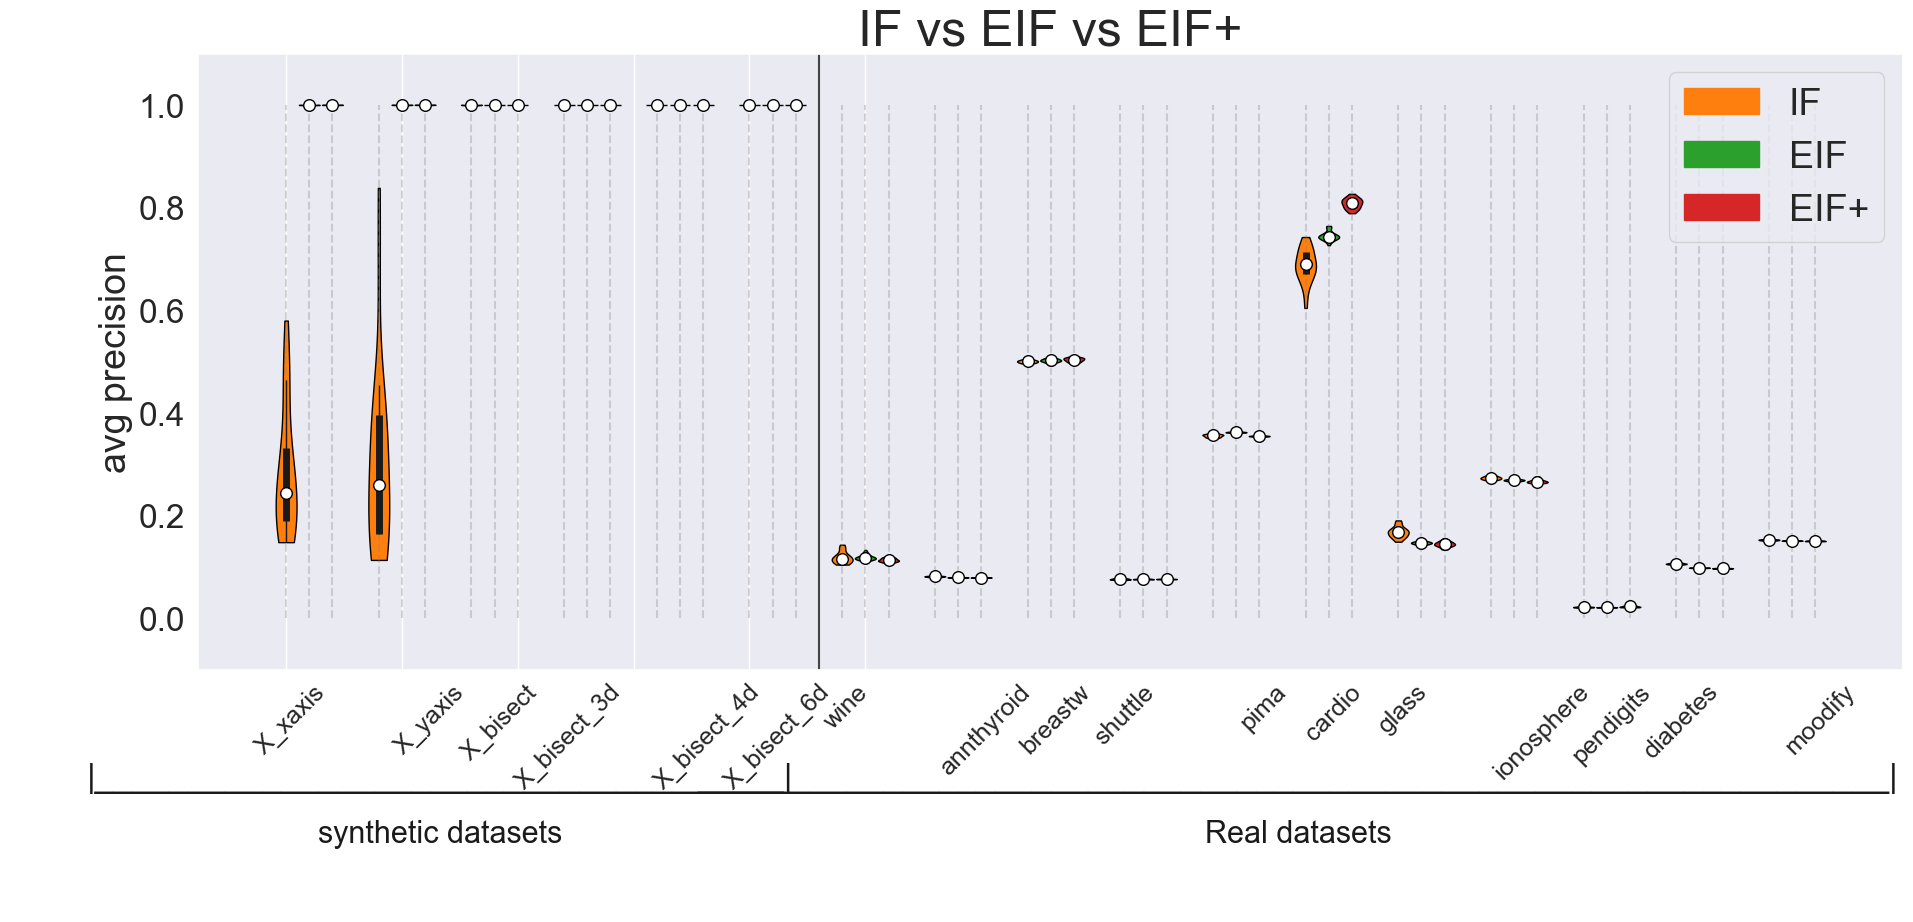

In [35]:
from matplotlib.lines import Line2D
plt.figure(figsize=(22, 8))  

parts = plt.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths = 0.9,positions=[x+(x//3) for x in range(len(data))])


for n,pc in enumerate(parts['bodies']):
        if n%3==0:
                pc.set_facecolor('tab:orange')
        elif n%3==1:
                pc.set_facecolor('tab:green')
        else:
                pc.set_facecolor('tab:red')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

inds = [x+(x//3) for x in range(len(data))]


for i in inds:
        plt.plot([i,i],[0,1],'--',c="tab:gray",alpha = 0.3)

plt.plot([23,23],[-0.5,1.5],c="k",alpha = 0.8)


quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

plt.scatter(inds, medians, marker='o', color='white',edgecolors="black", s=70, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.grid(axis = "y")
plt.title('IF vs EIF vs EIF+',fontsize = 36)
plt.ylim(-0.1,1.1)

plt.xticks([x+0.2 for x in inds if x%3==0],list(Precisions_scores_synt.keys()),minor = True,fontsize=18,rotation = 45)
plt.xticks(range(0,30,5),[""]*len(range(0,30,5)))
plt.yticks(fontsize=24)
plt.xlabel("\n \n ",fontsize=27)
plt.ylabel("avg precision",fontsize=27)

plt.annotate('|_____________________________________|', xy=(.200, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('synthetic datasets', xy=(.200, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')
plt.annotate('________________________________________________________________|', xy=(.59, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('Real datasets', xy=(.59, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')

orange_patch = mpatches.Patch(color='tab:orange', label='IF')
green_patch = mpatches.Patch(color='tab:green', label='EIF')
red_patch = mpatches.Patch(color='tab:red', label='EIF+')
plt.legend(handles=[orange_patch,green_patch,red_patch],loc="upper right",fontsize=27)
plt.savefig(os.getcwd()+'/avgIFvsEIFvsEIF+_synt.pdf',bbox_inches = "tight")
plt.show()


## FINAL VIOLIN PLOT

Without split

In [30]:
Prec_score.keys()

dict_keys(['X_xaxis', 'X_yaxis', 'X_bisect', 'X_bisect_3d', 'X_bisect_6d', 'wine', 'annthyroid', 'breastw', 'shuttle', 'pima', 'cardio', 'glass', 'ionosphere', 'pendigits', 'diabetes', 'moodify'])

In [ ]:
''' 
dataset_names_synt=['X_xaxis','X_yaxis','X_bisect','X_bisect_3d','X_bisect_6d']
dataset_names=['wine','annthyroid','breastw','shuttle','pima','cardio','glass',
             'ionosphere','pendigits','diabetes','moodify']
'''

In [36]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide')
data = []

dataset_names=['X_xaxis','X_yaxis','X_bisect','X_bisect_3d','X_bisect_6d',
                        'wine','annthyroid','breastw','shuttle','pima','cardio','glass',
                            'ionosphere','pendigits','diabetes','moodify']

'''
for key in dataset_names_synt:     
    for algorithm in ['IF',"EIF","EIF_plus"]:
        data.append(Precisions_scores_split[key][algorithm])
'''

for key in dataset_names:     
    for algorithm in ['IF',"EIF","EIF_plus"]:
        data.append(Prec_score[key][algorithm])
    
for i in range(len(data)):
    data[i] = [float(x) for x in data[i]]

In [37]:
dataset_names_complete=['X_xaxis','X_yaxis','X_bisect','X_bisect_3d','X_bisect_6d',
                        'wine','annthyroid','breastw','shuttle','pima','cardio','glass',
                            'ionosphere','pendigits','diabetes','moodify']

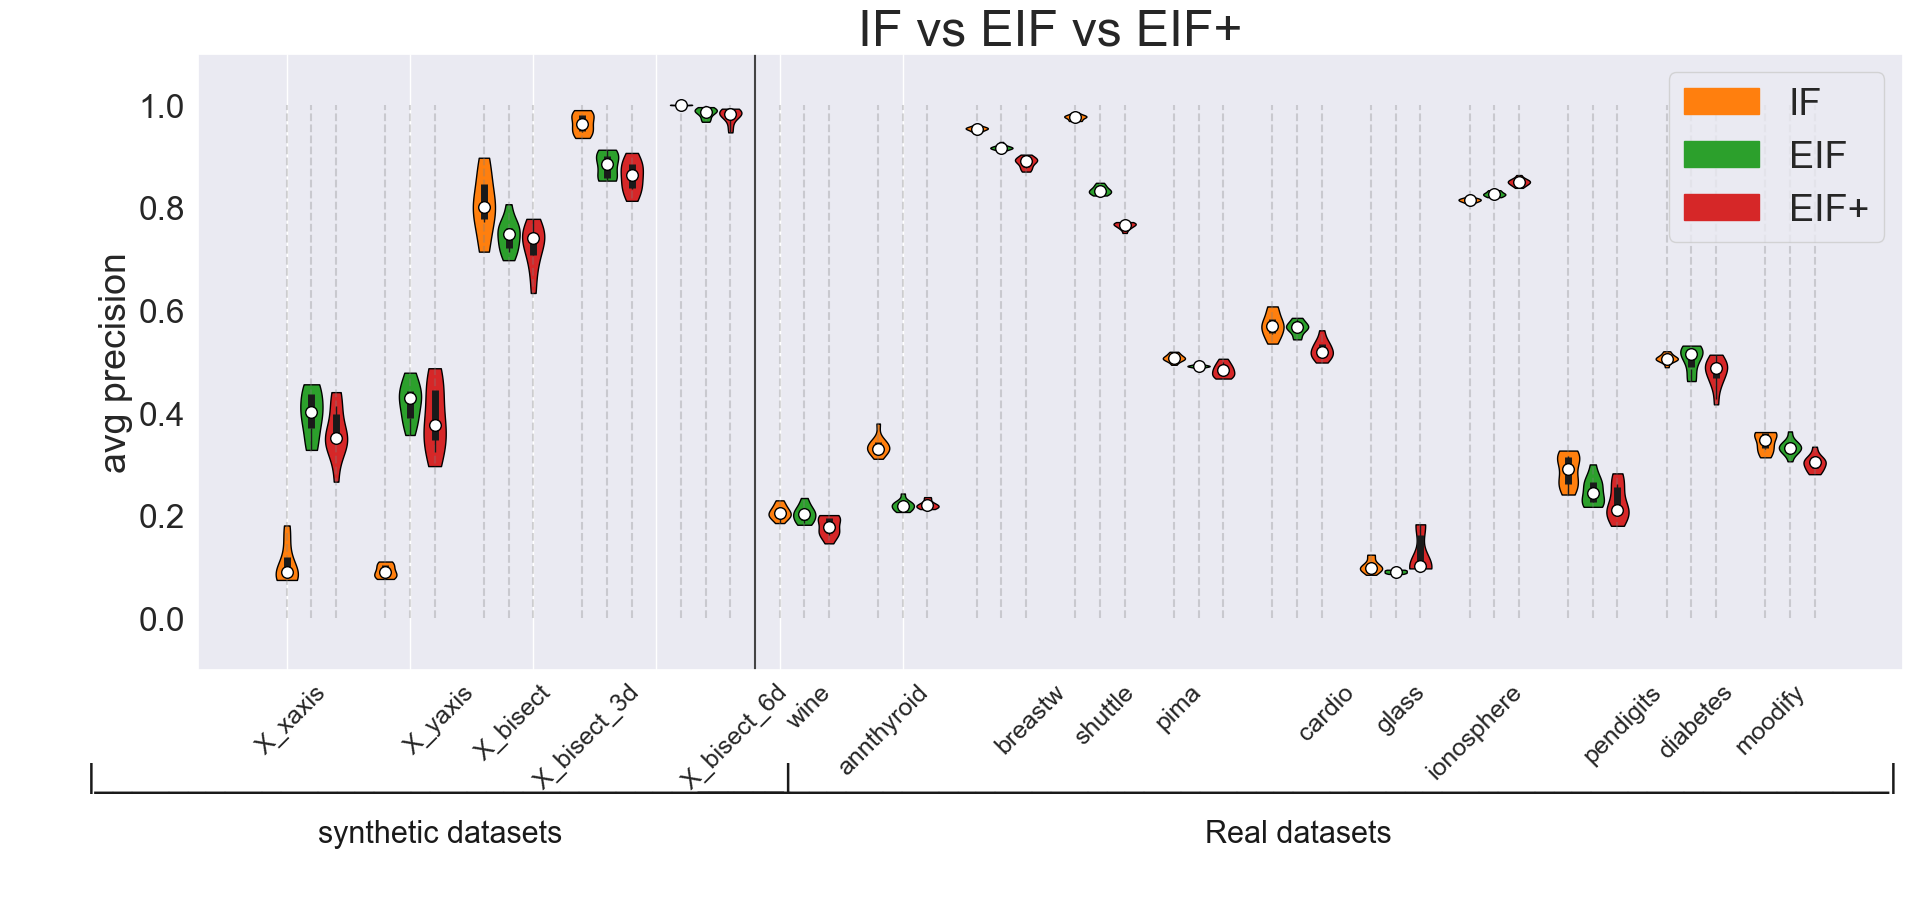

In [38]:
from matplotlib.lines import Line2D
plt.figure(figsize=(22, 8))  

parts = plt.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths = 0.9,positions=[x+(x//3) for x in range(len(data))])


for n,pc in enumerate(parts['bodies']):
        if n%3==0:
                pc.set_facecolor('tab:orange')
        elif n%3==1:
                pc.set_facecolor('tab:green')
        else:
                pc.set_facecolor('tab:red')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

inds = [x+(x//3) for x in range(len(data))]


for i in inds:
        plt.plot([i,i],[0,1],'--',c="tab:gray",alpha = 0.3)

plt.plot([19,19],[-0.5,1.5],c="k",alpha = 0.8)

quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

plt.scatter(inds, medians, marker='o', color='white',edgecolors="black", s=70, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.grid(axis = "y")
plt.title('IF vs EIF vs EIF+',fontsize = 36)
plt.ylim(-0.1,1.1)

plt.xticks([x+0.2 for x in inds if x%3==0],dataset_names_complete,minor = True,fontsize=18,rotation = 45)
plt.xticks(range(0,30,5),[""]*len(range(0,30,5)))
plt.yticks(fontsize=24)
plt.xlabel("\n \n ",fontsize=27)
plt.ylabel("avg precision",fontsize=27)

plt.annotate('|_____________________________________|', xy=(.200, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('synthetic datasets', xy=(.200, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')
plt.annotate('________________________________________________________________|', xy=(.59, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('Real datasets', xy=(.59, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')

orange_patch = mpatches.Patch(color='tab:orange', label='IF')
green_patch = mpatches.Patch(color='tab:green', label='EIF')
red_patch = mpatches.Patch(color='tab:red', label='EIF+')
plt.legend(handles=[orange_patch,green_patch,red_patch],loc="upper right",fontsize=27)
plt.savefig(os.getcwd()+'/Violin_Plot_no_split.pdf',bbox_inches = "tight")
plt.show()


With Split

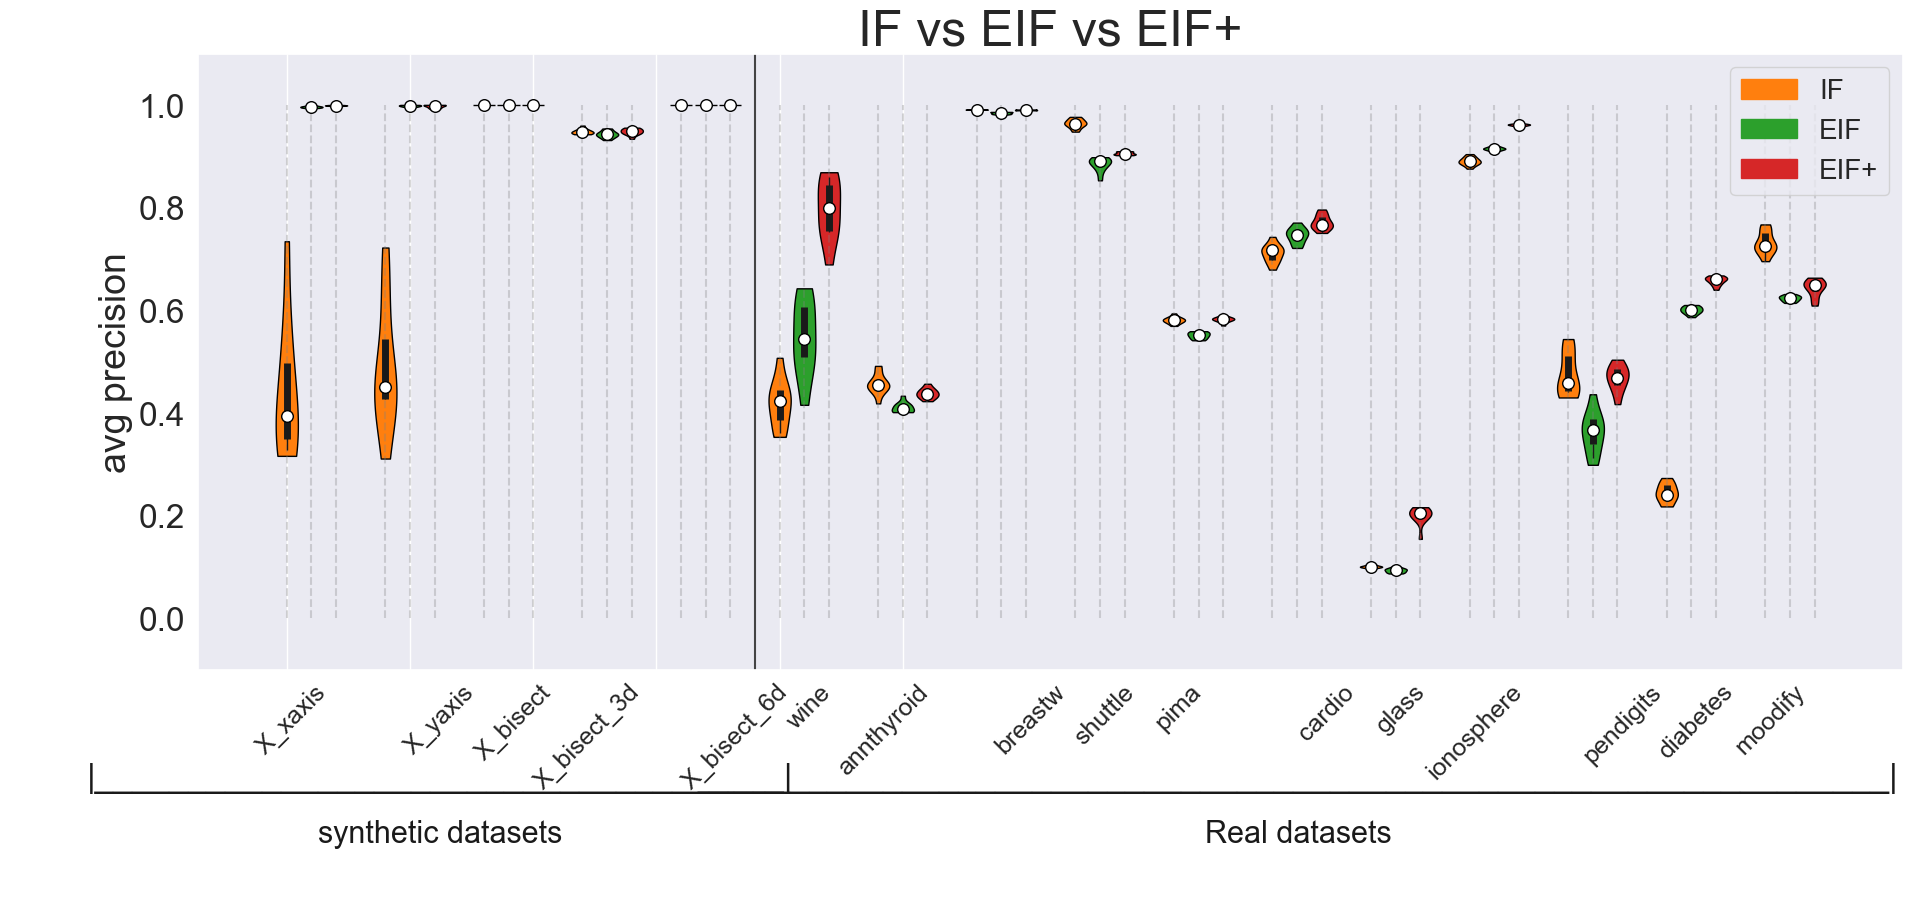

In [43]:
from matplotlib.lines import Line2D
plt.figure(figsize=(22, 8))  

parts = plt.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths = 0.9,positions=[x+(x//3) for x in range(len(data))])


for n,pc in enumerate(parts['bodies']):
        if n%3==0:
                pc.set_facecolor('tab:orange')
        elif n%3==1:
                pc.set_facecolor('tab:green')
        else:
                pc.set_facecolor('tab:red')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

inds = [x+(x//3) for x in range(len(data))]


for i in inds:
        plt.plot([i,i],[0,1],'--',c="tab:gray",alpha = 0.3)

plt.plot([19,19],[-0.5,1.5],c="k",alpha = 0.8)

quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

plt.scatter(inds, medians, marker='o', color='white',edgecolors="black", s=70, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.grid(axis = "y")
plt.title('IF vs EIF vs EIF+',fontsize = 36)
plt.ylim(-0.1,1.1)

plt.xticks([x+0.2 for x in inds if x%3==0],dataset_names_complete,minor = True,fontsize=18,rotation = 45)
plt.xticks(range(0,30,5),[""]*len(range(0,30,5)))
plt.yticks(fontsize=24)
plt.xlabel("\n \n ",fontsize=27)
plt.ylabel("avg precision",fontsize=27)

plt.annotate('|_____________________________________|', xy=(.200, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('synthetic datasets', xy=(.200, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')
plt.annotate('________________________________________________________________|', xy=(.59, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('Real datasets', xy=(.59, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')

orange_patch = mpatches.Patch(color='tab:orange', label='IF')
green_patch = mpatches.Patch(color='tab:green', label='EIF')
red_patch = mpatches.Patch(color='tab:red', label='EIF+')
plt.legend(handles=[orange_patch,green_patch,red_patch],loc="upper right",fontsize=20)
plt.savefig(os.getcwd()+'/Violin_Plot_with_split_new.pdf',bbox_inches = "tight")
plt.show()


## RANDOM FOREST FEATURE IMPORTANCE 

Compute the order of importance according to the Random Forest model for the datasets that are not included in the dictionary with the hard-coded Importance order that is placed in feture_selection.py in the function Random_Forest_Feature_importance.

The dataset missing the RF Feature Importance are: diabetes,moodify, and glass

In [16]:
def csv_dataset(name, path = "../data/"):
    datapath = path + name + ".csv"
    data=pd.read_csv(datapath,index_col=0)
    if 'Unnamed: 0' in data.columns:
        data=data.drop(columns=['Unnamed: 0'])
    
    X=data[data.columns[data.columns!='Target']]
    y=data['Target']
    
    X,y = drop_duplicates(X,y)
    print(name, "\n")
    print_dataset_resume(X,y)
    
    return X,y

In [17]:
def compute_rf_feat_imp(name):

    os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
    if name=='diabetes' or name=='moodify':
        X,y=csv_dataset(name,os.getcwd()+'\\')
    else:
        X,y=dataset(name,os.getcwd()+'\\')

    X,y=downsample(X,y)
    X_train,X_test=partition_data(X,y)
    scaler=StandardScaler()
    X=np.r_[X_train,X_test]
    X=scaler.fit_transform(X)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])

    RF=RandomForestClassifier(n_estimators=200)
    RF.fit(X,y)

    return RF.feature_importances_.argsort()[::-1]



In [18]:
Random_Forest_feat_imp={}
dataset_names=['wine','annthyroid','breastw','shuttle','pima','cardio','glass',
             'ionosphere','pendigits','diabetes','moodify']
for name in dataset_names:
    Random_Forest_feat_imp[name]=compute_rf_feat_imp(name)

wine 

[numero elementi = 129]
[percentage outliers = 0.07751937984496124]
[number features = 13]
[number outliers = 10]
annthyroid 

[numero elementi = 7062]
[percentage outliers = 0.07561597281223449]
[number features = 6]
[number outliers = 534]
downsampled to 2500
(2500, 6)
breastw 

[numero elementi = 449]
[percentage outliers = 0.5256124721603563]
[number features = 9]
[number outliers = 236]
shuttle 

[numero elementi = 49097]
[percentage outliers = 0.0715114976475141]
[number features = 9]
[number outliers = 3511]
downsampled to 2500
(2500, 9)
pima 

[numero elementi = 768]
[percentage outliers = 0.3489583333333333]
[number features = 8]
[number outliers = 268]
cardio 

[numero elementi = 1822]
[percentage outliers = 0.09604829857299671]
[number features = 21]
[number outliers = 175]
glass 

[numero elementi = 213]
[percentage outliers = 0.04225352112676056]
[number features = 9]
[number outliers = 9]
ionosphere 

[numero elementi = 350]
[percentage outliers = 0.357142857142857

In [30]:
Random_Forest_feat_imp['moodify']

array([ 6,  3,  2,  5,  8,  1,  0,  9, 10,  7,  4], dtype=int64)

### Glass 

In [8]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('glass',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X=np.r_[X_train,X_test]
X=scaler.fit_transform(X)
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_test.shape[0])
y=np.concatenate([y_train,y_test])
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_test=np.r_[X_train,X_test]

glass 

[numero elementi = 213]
[percentage outliers = 0.04225352112676056]
[number features = 9]
[number outliers = 9]


In [9]:
RF=RandomForestClassifier(n_estimators=200)
RF.fit(X,y)

RandomForestClassifier(n_estimators=200)

In [11]:
RF.feature_importances_.argsort()[::-1]

array([5, 0, 4, 1, 3, 6, 2, 7, 8], dtype=int64)

## Diabetes

In [19]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=csv_dataset('diabetes',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_test=np.r_[X_train,X_test]

diabetes 

[numero elementi = 85916]
[percentage outliers = 0.096582708692211]
[number features = 4]
[number outliers = 8298]
downsampled to 2500
(2500, 4)


In [20]:
RF=RandomForestClassifier(n_estimators=200)
RF.fit(X,y)

RandomForestClassifier(n_estimators=200)

In [22]:
RF.feature_importances_

array([0.1415643 , 0.14097875, 0.39931638, 0.31814058])

In [21]:
RF.feature_importances_.argsort()

array([1, 0, 3, 2], dtype=int64)

### Moodify

In [27]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=csv_dataset('moodify',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_test=np.r_[X_train,X_test]

moodify 

[numero elementi = 276260]
[percentage outliers = 0.1527112140736987]
[number features = 11]
[number outliers = 42188]
downsampled to 2500
(2500, 11)


In [28]:
RF=RandomForestClassifier(n_estimators=200)
RF.fit(X,y)

RandomForestClassifier(n_estimators=200)

In [29]:
RF.feature_importances_.argsort()[::-1]

array([ 6,  3,  2,  5,  8,  1,  0,  7,  9,  4, 10], dtype=int64)